## Ensemble Learning and Random Forests

### Ensemble Learning

If you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of pre‐
dictors is called an *ensemble*; thus, this technique is called *Ensemble Learning*, and an
Ensemble Learning algorithm is called an *Ensemble method*.

>A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier is called a *hard voting classifier*.

<figure>
<figcaption><h3> Hard voting classifier predictions</h3></figcaption>
<img src = "img/07_01.png">
</figure>

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a weak learner (mean‐
ing it does only slightly better than random guessing), the ensemble can still be a
strong learner (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse. How does this work? <br>
Suppose you build an ensemble containing 1,000 classifiers that are individ‐
ually correct only 51% of the time (barely better than random guessing). If you pre‐
dict the majority voted class, you can hope for up to 75% accuracy! However, this is
only true if all classifiers are perfectly independent, making uncorrelated errors,
which is clearly not the case since they are trained on the same data. They are likely to
make the same types of errors, so there will be many majority votes for the wrong
class, reducing the ensemble’s accuracy.

>Ensemble methods work best when the predictors are as independ‐
ent from one another as possible. One way to get diverse classifiers
is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving
the ensemble’s accuracy

Let's create a simple ensemble of two three:

In [25]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data # petal length and width
y = iris.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.5)
#I had to decrease the test_size to 0.5 otherwise, every model was getting an accuracy of 1 ):

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf,), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

To see each classifier’s predictions:

In [24]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.92
RandomForestClassifier 0.9333333333333333
SVC 0.92
VotingClassifier 0.9466666666666667


>As we can see, the `VotingClassifier` classifier has indeed the highest accuracy.

If all classifiers are able to estimate class probabilities (i.e., they have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called **soft
voting**. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities. 

In [27]:
#We have to remove the svm_clf since it does not predict probabilities
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf,),],
    voting='soft')
voting_clf.fit(X_train, y_train)

voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, voting_clf): 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9333333333333333
RandomForestClassifier 0.9466666666666667
VotingClassifier 0.9466666666666667


> HMM! A tie bewtween `RandomForestClassifier` and `VotingClassifier` !

### Bagging and Pasting

Apart from choosing defferent classifiers, Another approach is to use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
sampling is performed *with replacement*, this method is called **bagging** (short for
bootstrap aggregating). When sampling is performed *without replacement*, it is called
**pasting**.

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical **mode** for classification, or the **average** for regression.

>Predictors can all be trained in parallel, via different
CPU cores or even different servers. Similarly, predictions can be made in parallel.
This is one of the reasons why bagging and pasting are such popular methods: they
scale very well.

#### Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the `BaggingClassifier` class (or `BaggingRegressor` for regression). The `n_jobs` param‐
eter tells Scikit-Learn the number of CPU cores to use for training and predictions
(–1 tells Scikit-Learn to use all available cores)

In [33]:
#The Baggining Classifier needs more data, so i'm giving in more traing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1) #bootstrap=True means that the samples are drawn with replacement
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

>The `BaggingClassifier` automatically performs soft voting
instead of hard voting if the base classifier can estimate class proba‐
bilities (i.e., if it has a `predict_proba()` method), which is the case
with Decision Trees classifiers.

#### Out-of-Bag Evaluation

By default a `BaggingClassifier` samples m
training instances with replacement (`bootstrap=True`), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor. The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances.<br>
Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. You can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.
In Scikit-Learn, you can set `oob_score=True` when creating a `BaggingClassifier` to
request an automatic oob evaluation after training. 

In [34]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)

0.9523809523809523


The model should give 94% accuracy!

In [35]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9777777777777777

Okay, Great!😅 It gives 98% accuracy on test set (Of course, because the test set is very small).

In [38]:
bag_clf.oob_decision_function_[:10]

array([[0.        , 0.86842105, 0.13157895],
       [0.        , 0.01169591, 0.98830409],
       [0.        , 0.        , 1.        ],
       [0.        , 0.62686567, 0.37313433],
       [0.        , 0.01123596, 0.98876404],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.88020833, 0.11979167],
       [0.        , 1.        , 0.        ],
       [0.        , 0.2893401 , 0.7106599 ]])

## Random Forests

### Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features as well. This is con‐
trolled by two hyperparameters: `max_features` and `bootstrap_features`. They work
the same way as `max_samples` and `bootstrap`, but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the
input features.

Sampling both training instances *and* features is called the **Random Patches method**. Keeping all training instances (i.e., `bootstrap`=False and `max_samples`=1.0) but sampling features (i.e., `bootstrap_features`=True and/or `max_features` smaller than 1.0) is called the **Random Subspaces method**.

A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples`
set to the size of the training set. Instead of building a `BaggingClassifier` and pass‐
ing it a `DecisionTreeClassifier`, you can instead use the `RandomForestClassifier`
class, which is more convenient and optimized for Decision Trees (similarly, there is
a `RandomForestRegressor` class for regression tasks).

>With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a
`DecisionTreeClassifier` (to control how trees are grown), plus all the hyperpara‐
meters of a `BaggingClassifier` to control the ensemble itself.

In [41]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.9777777777777777

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node, it
searches for the best feature among a random subset of features.

>The following `BaggingClassifier` is
roughly equivalent to the previous `RandomForestClassifier`:

In [40]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### Extra-Trees

While growing trees in a `RandomForestClassifier` it is possible to make
trees even more *random* by also using random thresholds for each feature rather than
searching for the best possible thresholds. A forest of such extremely random trees is simply called an **Extremely Randomized Trees** ensemble (or **Extra-Trees** for short). This trades more bias for a
lower variance.

>One can create an `Extra-Trees` classifier using Scikit-Learn’s `ExtraTreesClassifier`
class. Its API is identical to the `RandomForestClassifier` class. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class.

>It is hard to tell in advance whether a `RandomForestClassifier`
will perform better or worse than an `ExtraTreesClassifier`. Gen‐
erally, the only way to know is to try both and compare them using
cross-validation (and tuning the hyperparameters using grid
search).

### Feature Importance

During training `RandomForest`, Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest). More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it.
Scikit-Learn computes this score automatically for each feature after training, then it
scales the results so that the sum of all importances is equal to 1. You can access the
result using the `feature_importances_` variable.

In [42]:
rnd_clf.feature_importances_

array([0.11095775, 0.02625148, 0.46391246, 0.3988783 ])

## Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. *The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its prede‐
cessor.*

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predic‐
tors focusing more and more on the hard cases. This is the technique used by **AdaBoost**.<br>
For example, to build an AdaBoost classifier, a first base classifier (such as a `DecisionTree`) is trained and used to make predictions on the training set. The relative weight
of misclassified training instances is then increased. A second classifier is trained
using the updated weights and again it makes predictions on the training set, weights
are updated, and so on.

<figure>
<figcaption><h3>Decision boundaries of consecutive predictors</h3></figcaption>
<img src = "img/07_02.png">
</figure>

>This sequential learning technique has some
similarities with *Gradient Descent*, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, `AdaBoost` adds predictors to the ensemble,
gradually making it better.

Once all predictors are trained, the ensemble makes predictions very much like bag‐
ging or pasting, except that predictors have different weights depending on their
overall accuracy on the weighted training set.

>There is one important drawback to this sequential learning techni‐
que: it cannot be parallelized (or only partially), since each predic‐
tor can only be trained after the previous predictor has been
trained and evaluated. As a result, it does not scale as well as bag‐
ging or pasting.

#### How Does it Works?

Each instance weight $w_(i)$ is initially
set to $\frac{1}{m}$. A first predictor is trained and its weighted error rate $r_1$ is computed on the
training set;

<figure>
<figcaption><h3>Weighted error rate of the jth predictor</h3></figcaption>
<img src = "img/07_03.png">
</figure>

The predictor’s weight $\alpha_j$ is then computed using, 
$$\alpha_j = \eta \log \left( \frac{1-r_j}{r_j} \right)$$
where $η$ is the learning rate hyperparameter 

Next the instance weights are updated using the following formula:

<figure>
<figcaption><h3> Weight Update Rule</h3></figcaption>
<img src = "img/07_04.png">
</figure>

The misclassified instancesare boosted. Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^mw^{(i)}$ ).
Finally, a new predictor is trained using the updated weights, and the whole process is
repeated (the new predictor’s weight is computed, the instance weights are updated,
then another predictor is trained, and so on). The algorithm stops when the desired
number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors
and weighs them using the predictor weights αj. The predicted class is the one that
receives the majority of weighted votes 
$$\hat{y} = \arg\max_{y} \sum_{j=1}^N \alpha_j \cdot y_j$$
N = Number of predictors

The following code trains an AdaBoost classifier based on 200 Decision Stumps using
Scikit-Learn’s `AdaBoostClassifier` class (there is also an `AdaBoostRegressor` class). **A Decision Stump** is a Decision Tree with `max_depth=1 `—in
other words, a tree composed of a single decision node plus two leaf nodes.

In [45]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=200,
algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### Gradient Boosting

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, **this method tries to fit the new predictor to the residual errors made by the previous predictor.**

#### How Does it Works?

Let’s go through a simple regression example using Decision Trees as the base predic‐
tors. First, let’s
fit a `DecisionTreeRegressor` to the training set

In [56]:
import numpy as np
X = np.linspace(-4.5, 5, 400)
noise = np.random.normal(0, 1.5, X.shape)
y = X**2 + noise
X = X.reshape(-1, 1) # make the dimension of X suitable for the model

In [57]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first
predictor:

In [58]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

Then we train a third regressor on the residual errors made by the second predictor:

In [59]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:


In [61]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

<figure>
<figcaption><h3> Gradient Boosting</h3></figcaption>
<img src = "img/07_05.png">
</figure>

A simpler way to train GBRT ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class. Much like the `RandomForestRegressor` class, it has hyperparameters to
control the growth of Decision Trees (e.g., `max_depth`, `min_samples_leaf`, and so on),
as well as hyperparameters to control the ensemble training, such as the number of
trees (`n_estimators`).

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1, you will need more trees in the ensemble to fit the train‐
ing set, but the predictions will usually generalize better. This is a regularization tech‐
nique called **shrinkage**.

<figure>
<figcaption><h3>GBRT ensembles with not enough predictors (left) and too many (right)</h3></figcaption>
<img src = "img/07_06.png">
</figure>

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the `staged_predict()` method: it
returns an iterator over the predictions made by the ensemble at each stage of training. 

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred)
    for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=45)

**Even though we started with `n_estimator = 120`, using early stopping, we find that the optimal number of estimators is 45.**

45

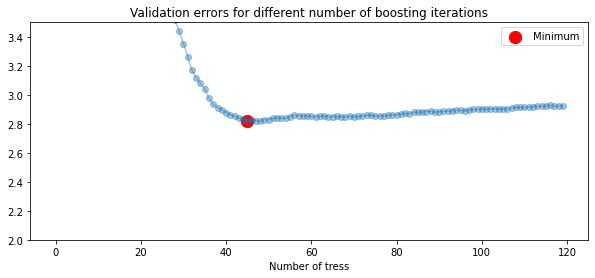

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(errors, 'o-', alpha=0.4)
optimal = np.argmin(errors)
optimal_erro = errors[optimal]
plt.scatter(optimal, optimal_erro, marker='o', color='r', s=150, label='Minimum')
title = "Validation errors for different number of boosting iterations"
plt.xlabel('Number of tress')
plt.title(title)
plt.legend()
plt.ylim([2, 3.5]);

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting `warm_start=True`, which makes ScikitLearn keep existing trees when the `fit()` method is called, allowing incremental
training. 

In [80]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
    if error_going_up == 5:
        break # early stopping

The `GradientBoostingRegressor` class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instan‐
ces, selected randomly. As you can probably guess by now, this trades a higher bias
for a lower variance. It also speeds up training considerably. This technique is called
*Stochastic Gradient Boosting*.<br>
It is also possible to use Gradient Boosting with other cost functions.
This is controlled by the `loss` hyperparameter.

### XGBoost

`XGBoost` is an optimized implementation of Gradient Boosting. It is available
in the popular python library `XGBoost`, which stands for *Extreme Gradient Boosting*.
This is extremely fast, scalable
and portable. In fact, `XGBoost` is often an important component of the winning
entries in ML competitions. `XGBoost’s` API is quite similar to Scikit-Learn’s:

In [81]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

`XGBoost` also offers several nice features, such as automatically taking care of early
stopping:

In [82]:
xgb_reg.fit(X_train, y_train,
eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:7.67425
[1]	validation_0-rmse:5.58704
[2]	validation_0-rmse:4.08722
[3]	validation_0-rmse:3.07933
[4]	validation_0-rmse:2.45200
[5]	validation_0-rmse:2.07275
[6]	validation_0-rmse:1.85389
[7]	validation_0-rmse:1.75117
[8]	validation_0-rmse:1.71977
[9]	validation_0-rmse:1.70463
[10]	validation_0-rmse:1.71308
[11]	validation_0-rmse:1.71465


### Stacking

Stacking is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble,
why don’t we train a model to perform this aggregation?

The figure shows such an
ensemble performing a regression task on a new instance. Each of the bottom three
predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor
(called a blender, or a meta learner) takes these predictions as inputs and makes the
final prediction (3.0).

<figure>
<figcaption><h3>Aggregating predictions using a blending predictor</h3></figcaption>
<img src = "img/07_07.png">
</figure>

To train the blender, a common approach is to use a hold-out set. First, the training set is split in two subsets. The first subset is used to train the
predictors in the first layer. Next, the first layer predictors are used to make predictions on the second (held-out)
set. This ensures that the predictions are “clean,” since the predictors
never saw these instances during training. Now for each instance in the hold-out set there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set three-dimensional),
and keeping the target values. The blender is trained on this new training set, so it
learns to predict the target value given the first layer’s predictions.

<figure>
<figcaption><h3>Training the blender</h3></figcaption>
<img src = "img/07_08.png">
</figure>

It is actually possible to train several different blenders this way (e.g., one using Lin‐
ear Regression, another using Random Forest Regression, and so on). Once the training is done, we can make
a prediction for a new instance by going through each layer sequentially, as shown:

<figure>
<figcaption><h3>Predictions in a multilayer stacking ensemble</h3></figcaption>
<img src = "img/07_09.png">
</figure>

Unfortunately, Scikit-Learn does not support stacking directly. We can use <a href="https://github.com/Menelau/DESlib">DESlib</a> though.